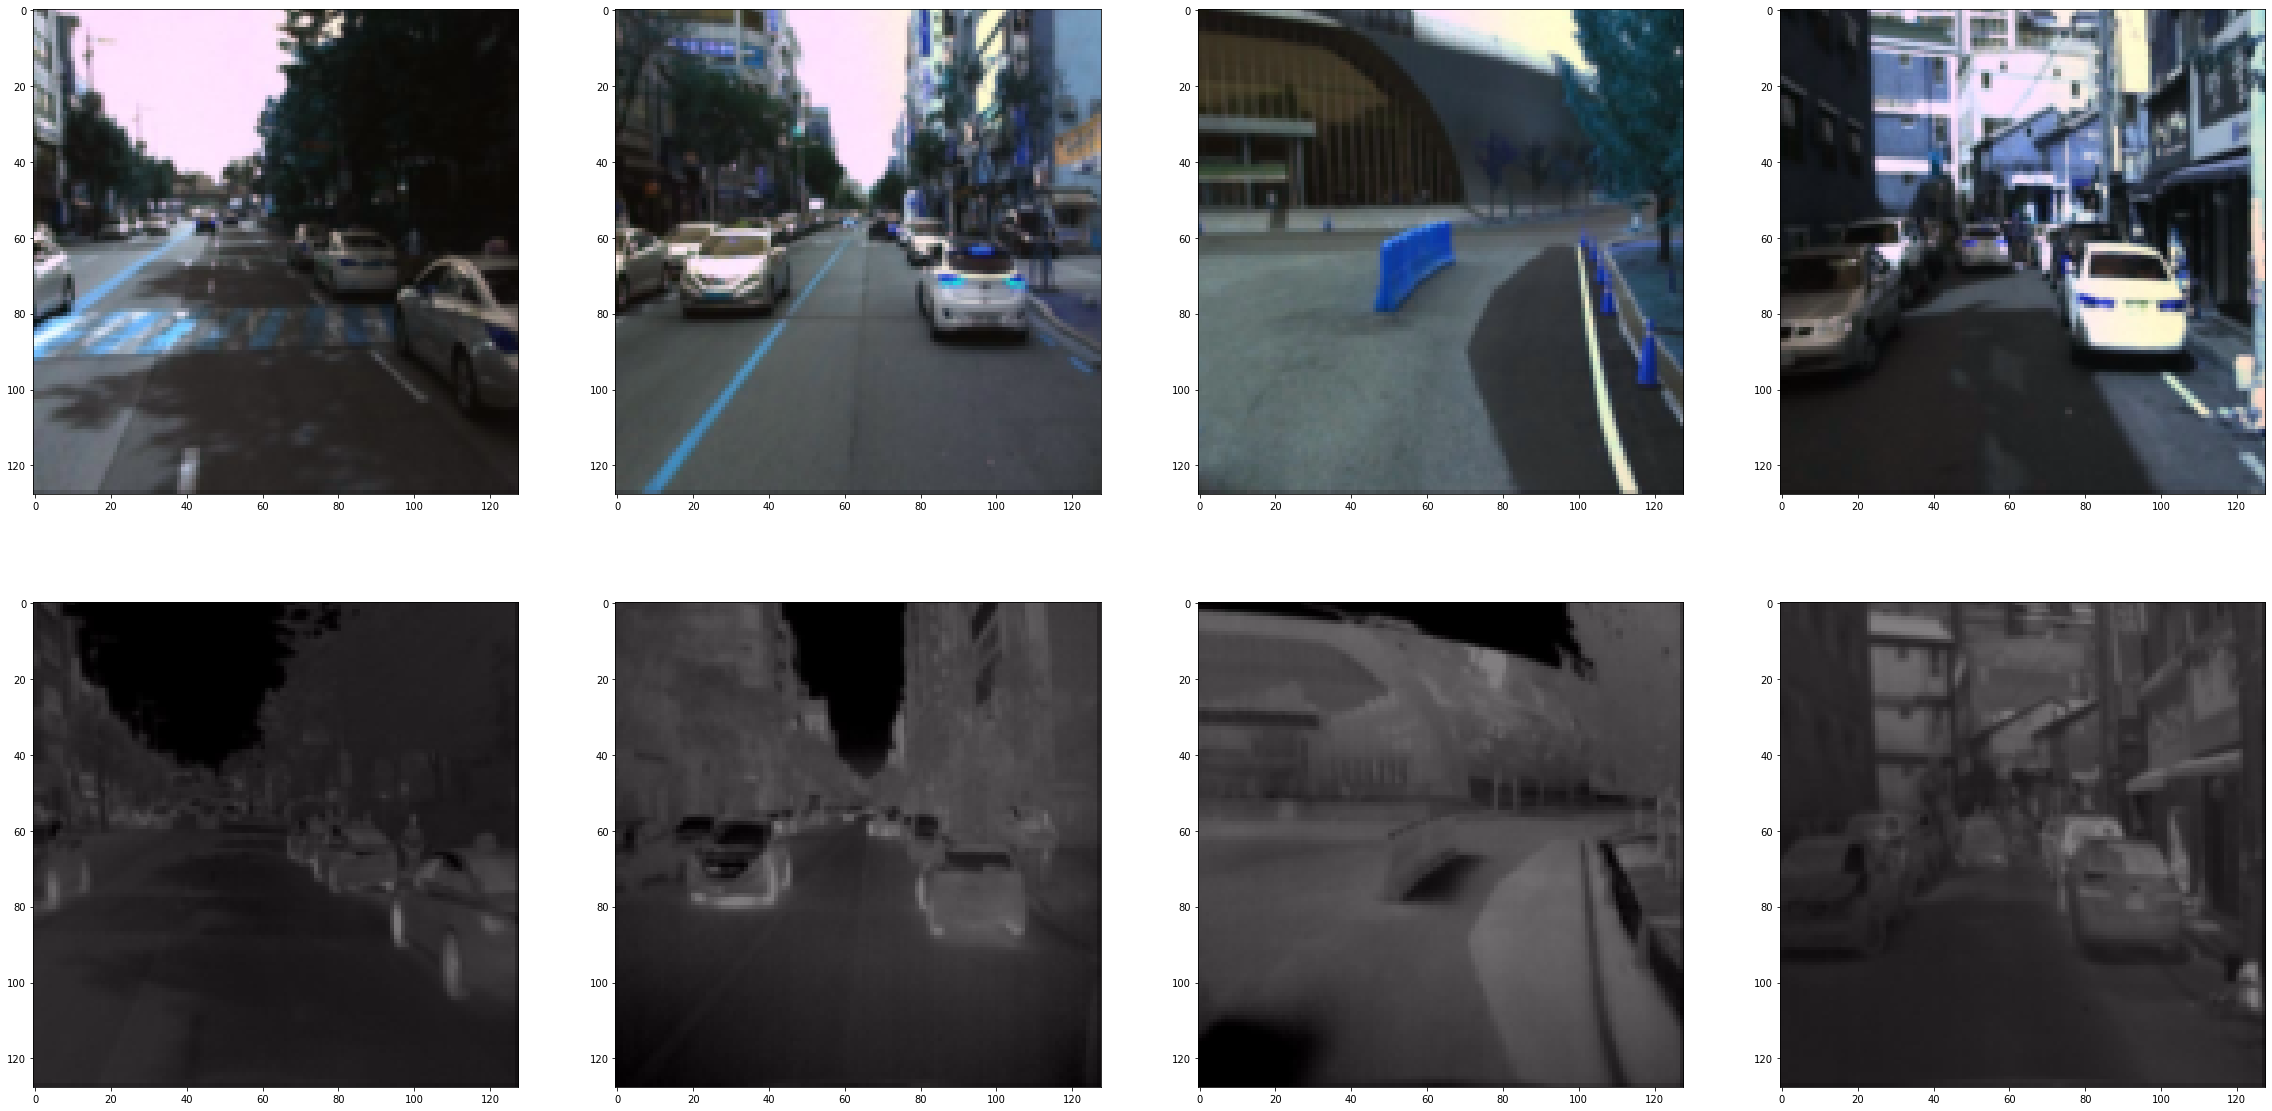

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import freeze_support
from skimage import io
from PIL import Image

transforms_x = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128))
])

transforms_y = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128))
])

BATCH_SIZE = 4

class custom_dataset(Dataset):

    def __init__(self, root, transforms_x, transforms_y):

        self.root = root
        self.folders = os.listdir(root)
        self.X_path = os.listdir(root+self.folders[0])
        self.Y_path = os.listdir(root+self.folders[1])
        self.dataset_length = len(self.X_path)
        self.transforms_x = transforms_x
        self.transforms_y = transforms_y
        
    def __getitem__(self, index):
         
        X_path = self.root+self.folders[0]+'//'+self.X_path[index]
        X = np.array(cv2.imread(X_path)).astype(np.uint8)

        Y_path = self.root+self.folders[1]+'//'+self.Y_path[index]
        Y = np.array(cv2.imread(Y_path)).astype(np.uint8)

        X = torch.tensor(np.array(self.transforms_x(X))).permute(2, 0, 1)
        Y = torch.tensor(np.array(self.transforms_y(Y))).permute(2, 0, 1)

        return X,Y

    def __len__(self):
        return len(self.X_path)

    
root_train = "train\\"
root_val = "val\\"

train_dataset = custom_dataset(root_train, transforms_x, transforms_y)
val_dataset = custom_dataset(root_val, transforms_x, transforms_y)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, 
                        shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, 
                        shuffle=True)

plt.figure(figsize=(BATCH_SIZE*10,20))
for X,Y in train_loader:
    i = 1
    for x,y in zip(X,Y):
        plt.subplot(2, BATCH_SIZE, i)
        plt.imshow(x.permute(1, 2, 0))
        plt.subplot(2, BATCH_SIZE, i+BATCH_SIZE)
        plt.imshow(y.permute(1, 2, 0))
        i+=1
    break
plt.show()
plt.close()

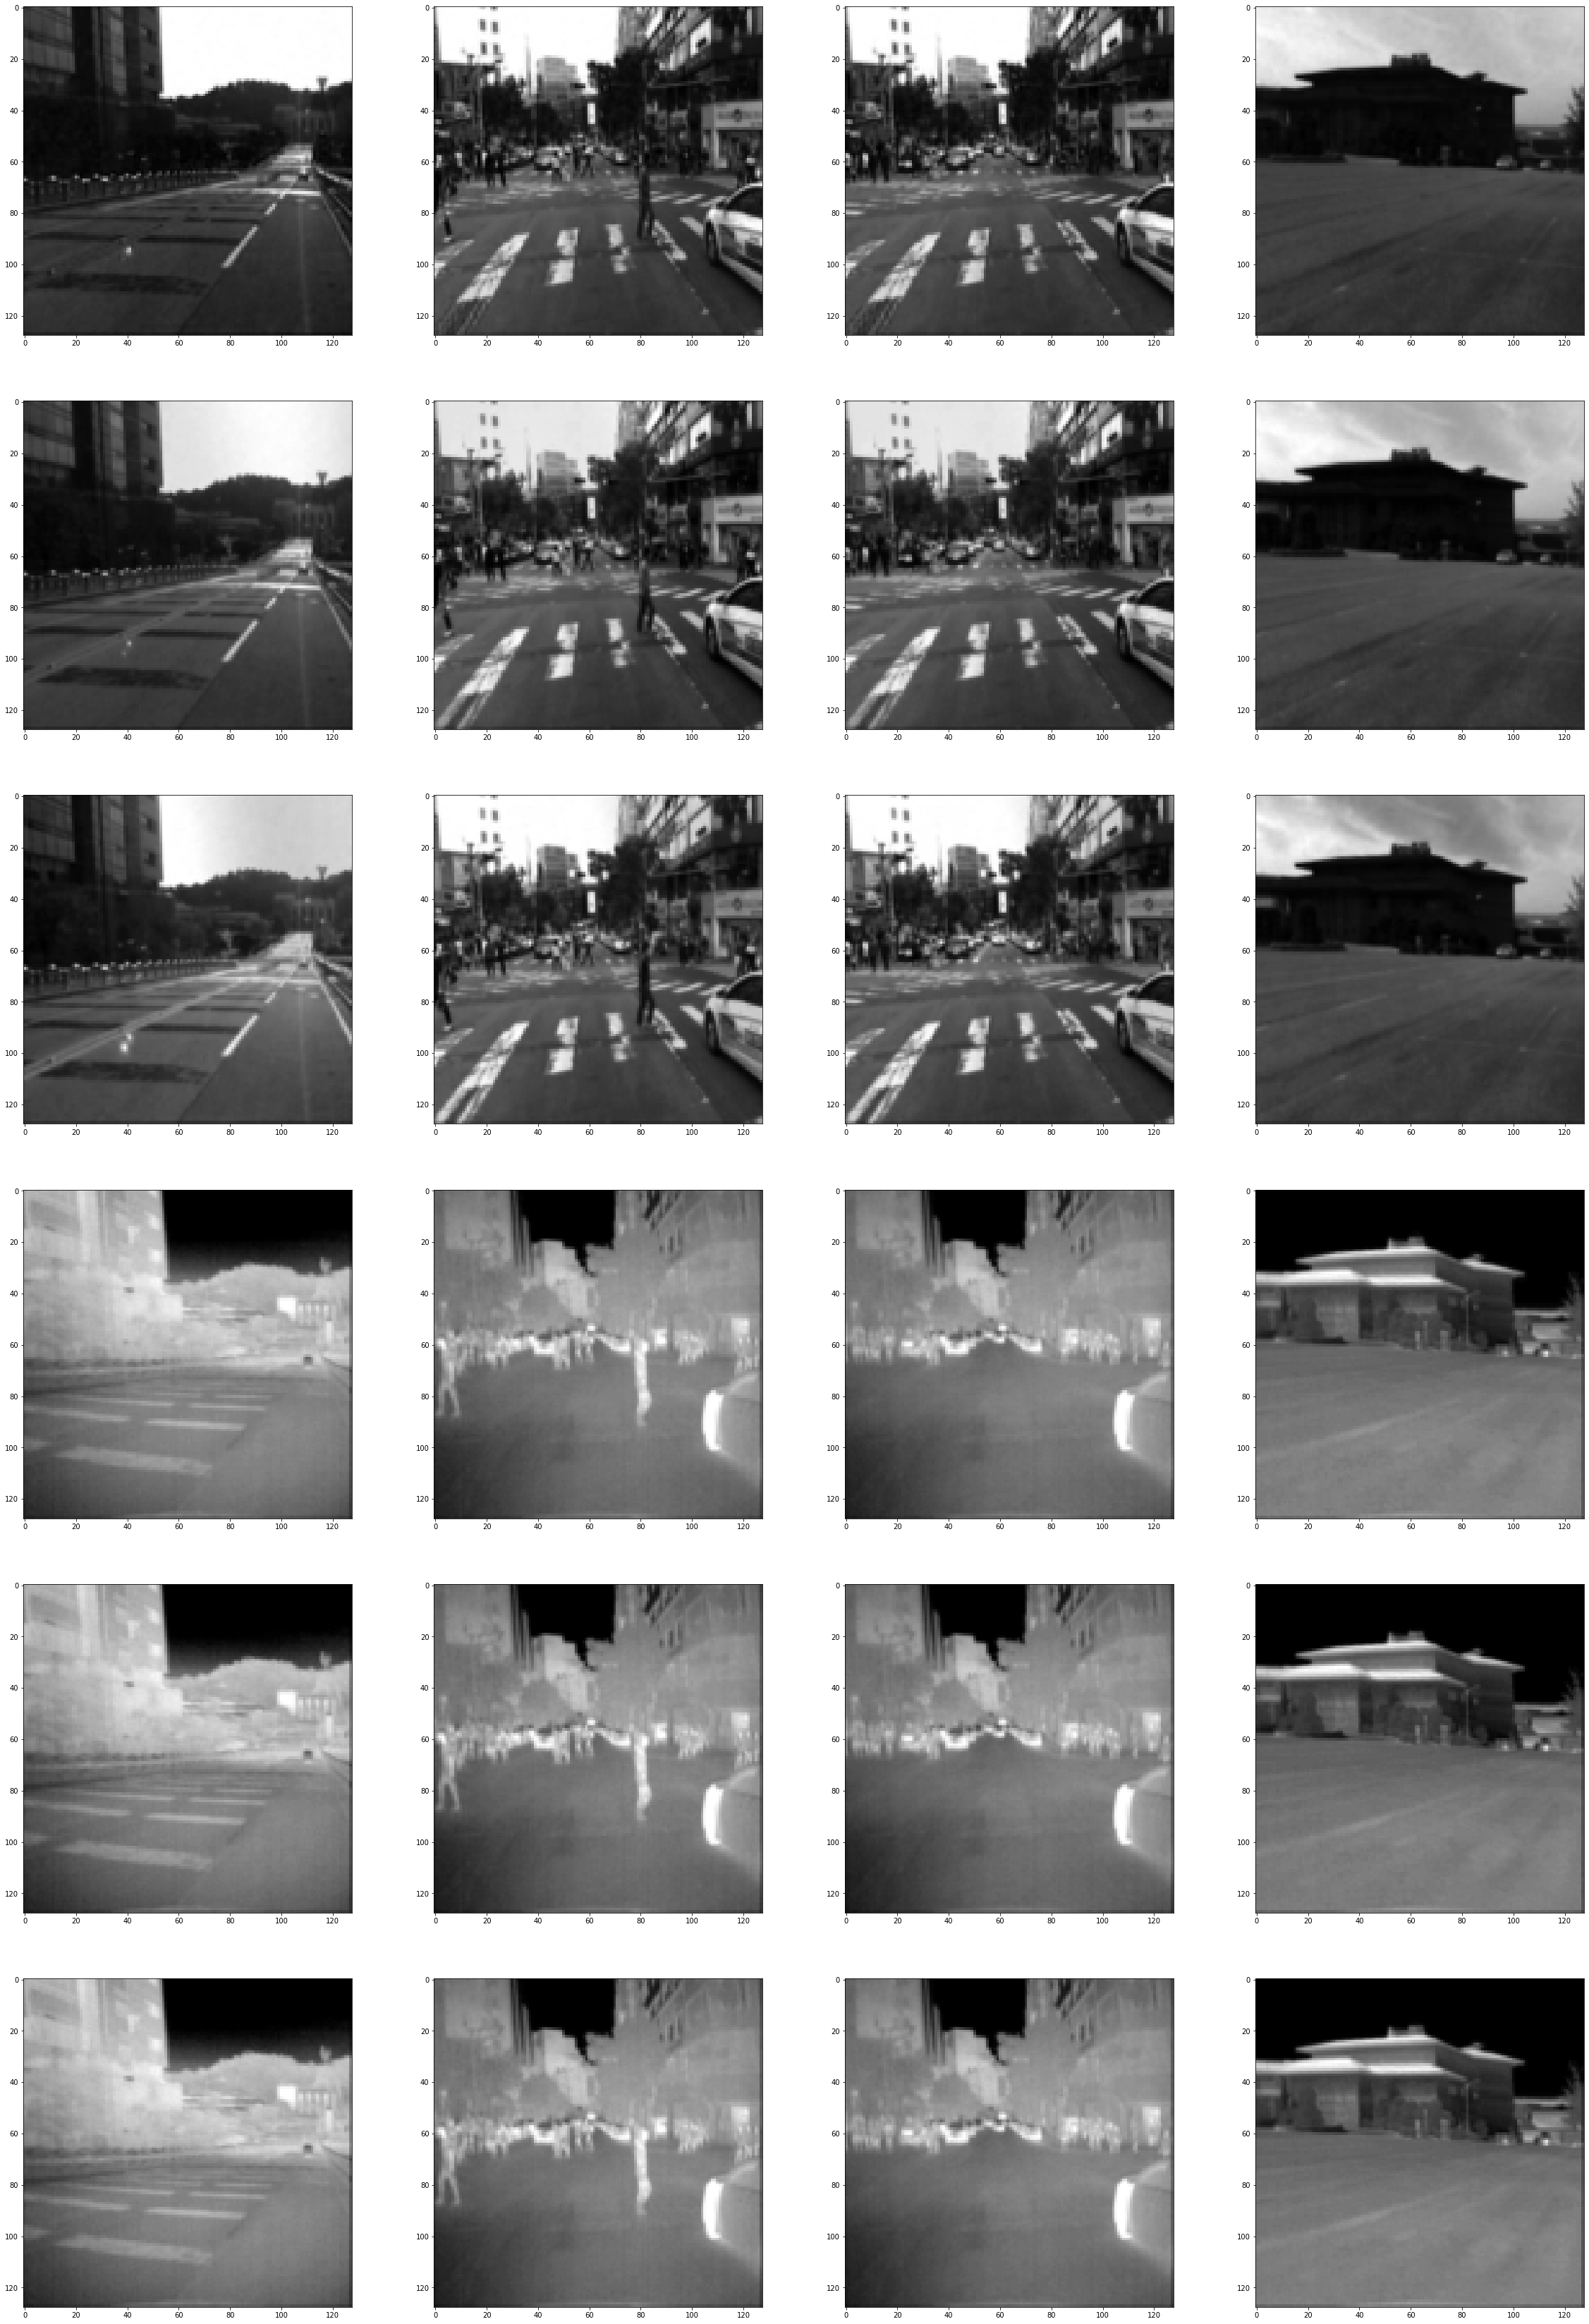

In [2]:
plt.figure(figsize=(BATCH_SIZE*10,3*20))
for X,Y in train_loader:
    i = 1
    for x,y in zip(X,Y):
        for j in range(6):
            if 0<=j<=2:
                plt.subplot(6, BATCH_SIZE, i+4*j)
                plt.imshow(x[j], cmap="gray")
            else:
                plt.subplot(6, BATCH_SIZE, i+4*j)
                plt.imshow(y[j-3], cmap="gray")
        i+=1
    break
plt.show()
plt.close()

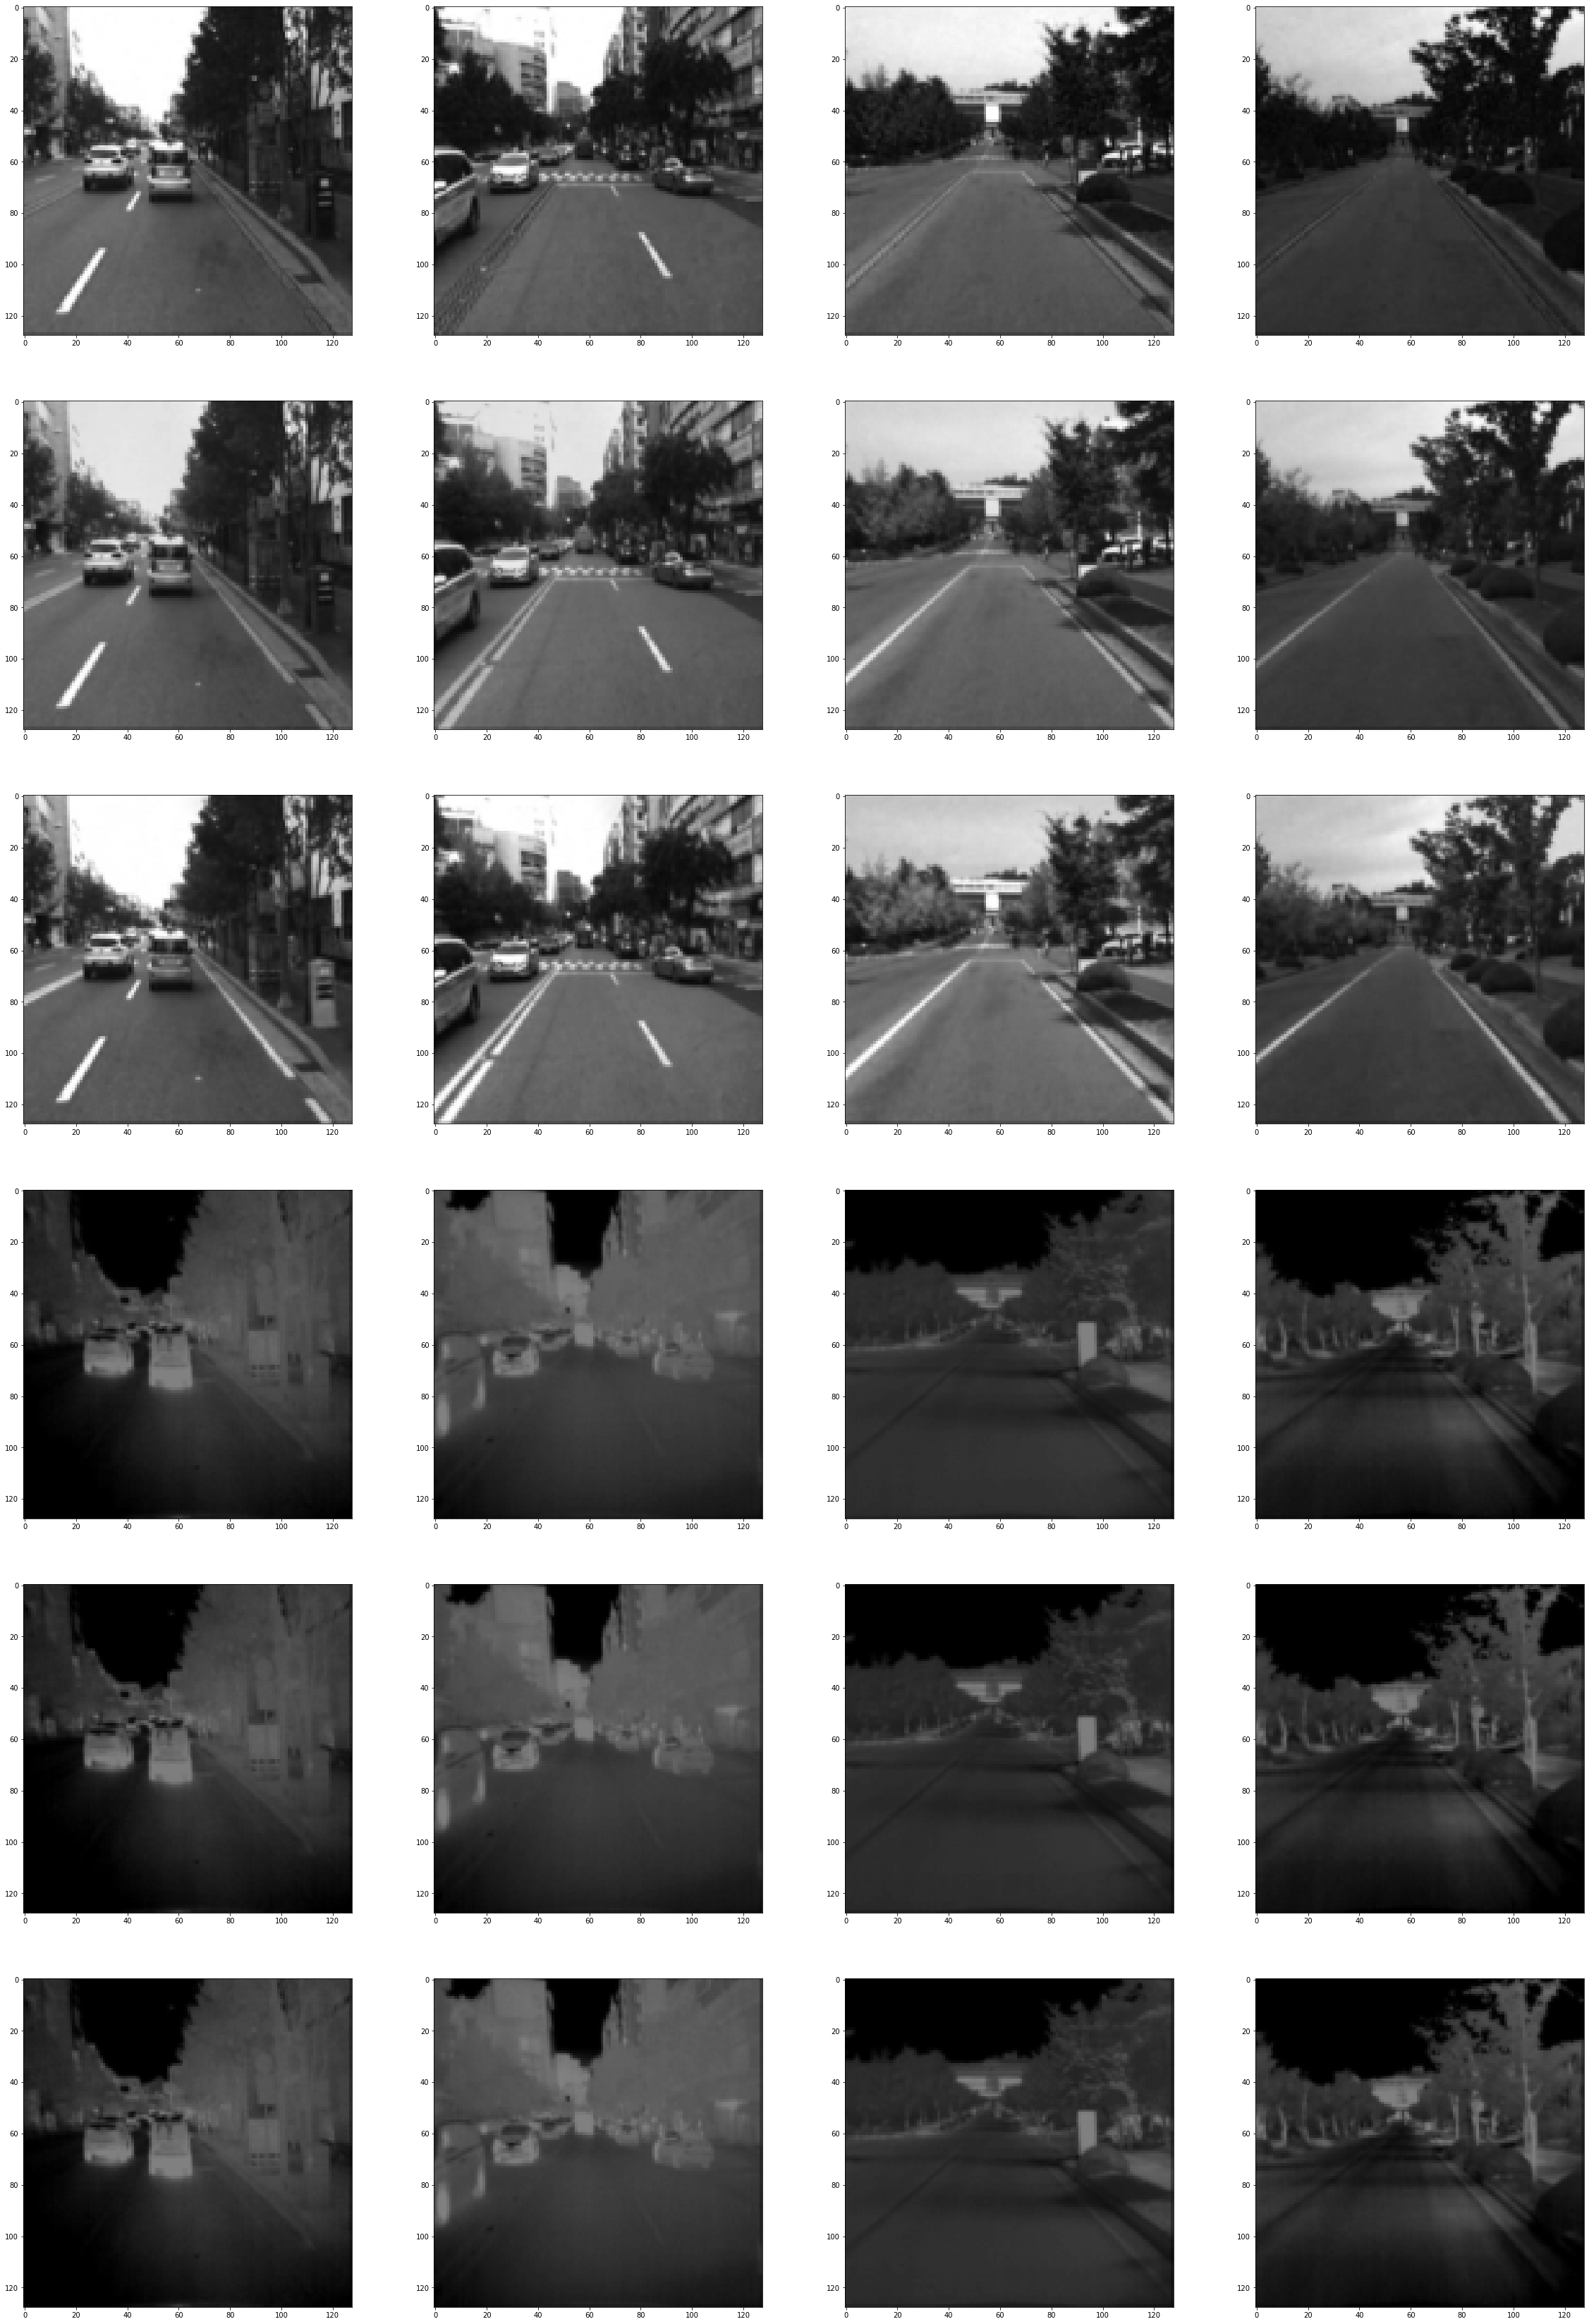

In [3]:
plt.figure(figsize=(BATCH_SIZE*10,3*20))
for X,Y in train_loader:
    i = 1
    for x,y in zip(X,Y):
        for j in range(6):
            if 0<=j<=2:
                plt.subplot(6, BATCH_SIZE, i+4*j)
                plt.imshow(x[j], cmap="gray", vmin=0, vmax=255, interpolation='none')
            else:
                plt.subplot(6, BATCH_SIZE, i+4*j)
                plt.imshow(y[j-3], cmap="gray", vmin=0, vmax=255, interpolation='none')
        i+=1
    break
plt.show()
plt.close()

In [5]:
print(x.shape, y.shape)
print(x.max(), x.min(), y.max(), y.min())

torch.Size([3, 128, 128]) torch.Size([3, 128, 128])
tensor(255, dtype=torch.uint8) tensor(3, dtype=torch.uint8) tensor(130, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


In [6]:
plt.figure(figsize=(30,20))
for i in range(3):
    temp = [y[i].max() for _,bY in train_loader for y in bY]
    plt.subplot(2, 3, i+1)
    plt.hist(temp)

for i in range(3):
    temp = [y[i].min() for _,bY in train_loader for y in bY]
    plt.subplot(2, 3, i+4)
    plt.hist(temp)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from models import baseline, baseline_v2, segformer, maskformer
from vgg_loss import VGGLoss

LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-5
MAX_PSNR = 0
EPOCHS = 1000
ALPHA = 0.3

def psnr(predicted, target):
   
    mse = F.mse_loss(predicted, target, reduction='none').mean(dim=(1, 2, 3))
    psnr = 20 * torch.log10(torch.tensor([torch.max(t) for t in target]).to('cuda')) - 10 * torch.log10(mse)
    
    return psnr.mean()  

PATH = "models\\baseline_vgg.pth"
# model = smp.Unet(
#     encoder_name="resnet34",       
#     encoder_weights="imagenet",   
#     in_channels=3,                 
#     classes=3,                    
# )
model = baseline()
# model.load_state_dict(torch.load(PATH))
MAE = nn.L1Loss()
MSE = nn.MSELoss()
VGG  = VGGLoss()
model = model.to('cuda')

optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

for epoch in range(EPOCHS):

    model.train()  
    total_loss = 0.0

    for X, Y in train_loader:

        X, Y = X.to('cuda').float(), Y.to('cuda').float()
        outputs = model(X)

        loss = (ALPHA * MAE(outputs, Y)) + ((1 - ALPHA) * VGG(outputs, Y))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()  
    val_loss = 0.0
    val_psnr = 0

    with torch.no_grad():

        for X, Y in val_loader:

            X, Y = X.to('cuda').float(), Y.to('cuda').float()
            outputs = torch.round(model(X))

            loss = (ALPHA * MAE(outputs, Y)) + ((1 - ALPHA) * VGG(outputs, Y))
            val_loss += loss.item()
            val_psnr += psnr(outputs, Y)
            
    avg_val_loss = val_loss/len(val_loader)
    avg_val_psnr = val_psnr/len(val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Training Loss {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val PSNR: {avg_val_psnr:.4f}")

    if(avg_val_psnr > MAX_PSNR):

        MAX_PSNR = avg_val_psnr
        torch.save(model.state_dict(), PATH)
        print("Checkpointing--{}".format(avg_val_psnr))

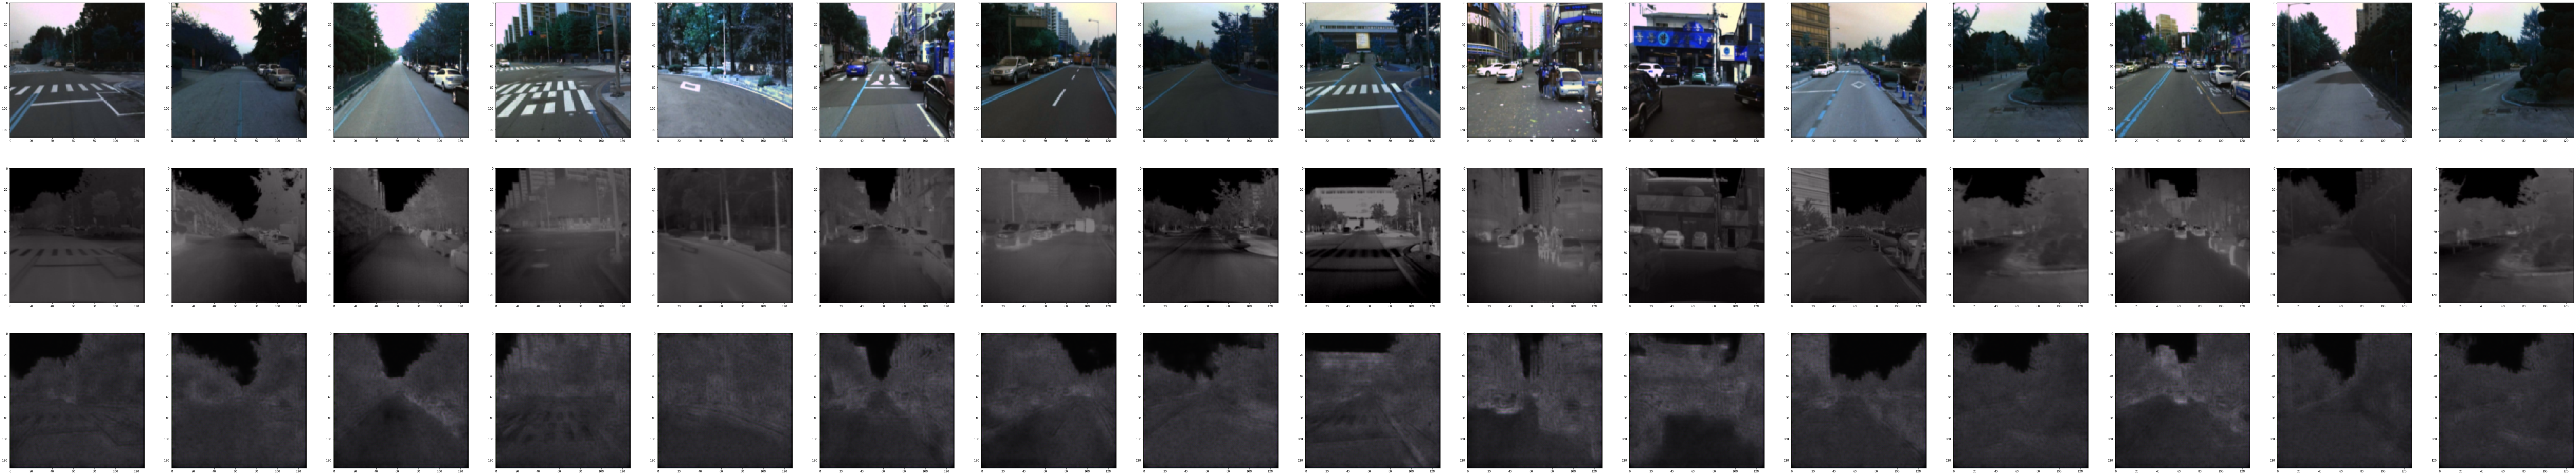

In [6]:
from models import baseline, segformer


PATH = "models\\baseline_vgg.pth"
# model = smp.Unet(
#     encoder_name="resnet341",       
#     encoder_weights="imagenet",   
#     in_channels=3,                 
#     classes=3,                    
# )
model = baseline()
model.load_state_dict(torch.load(PATH))

plt.figure(figsize=(BATCH_SIZE*10, 30))

for X,Y in val_loader:
    i = 1
    Y_hat = model(X.float())
    for x,y,y_hat in zip(X,Y,Y_hat):
        plt.subplot(3, BATCH_SIZE, i)
        plt.imshow(x.permute(1, 2, 0))
        plt.subplot(3, BATCH_SIZE, BATCH_SIZE+i)
        plt.imshow(y.permute(1, 2, 0))
        plt.subplot(3, BATCH_SIZE, 2*BATCH_SIZE+i)
        plt.imshow(torch.round(y_hat.permute(1, 2, 0).cpu().data).int())
        i+=1
    break

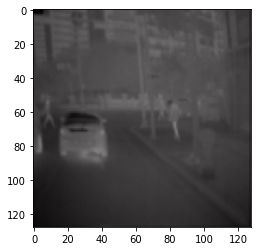

In [5]:
plt.imshow(y.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


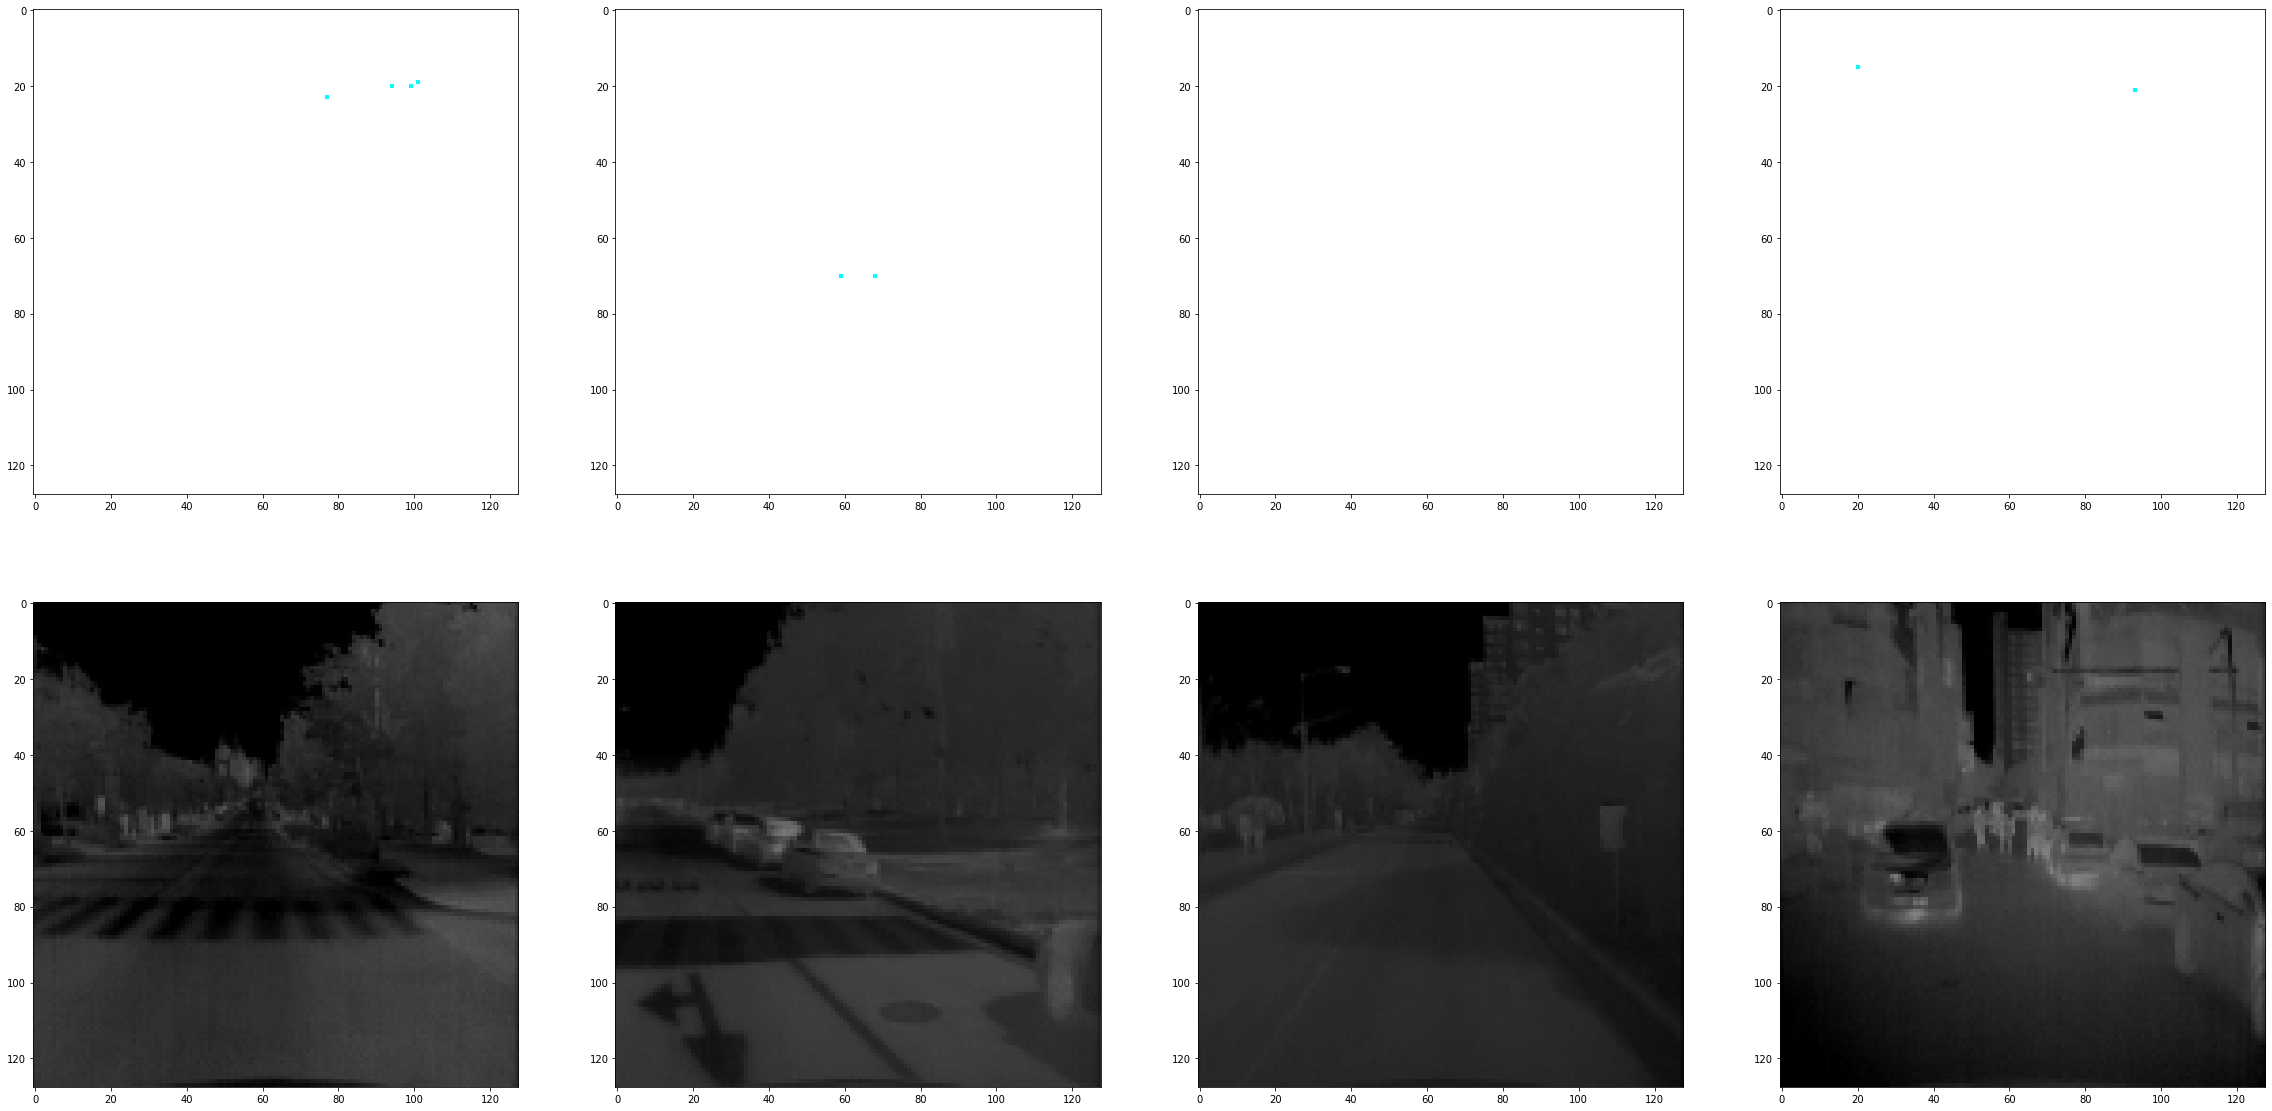

In [6]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import random
from torch.utils.data import Dataset

BATCH_SIZE = 4

class custom_dataset(Dataset):

    def __init__(self, root):

        self.root = root
        self.folders = os.listdir(root)
        self.X_path = os.listdir(os.path.join(root, self.folders[0]))
        self.Y_path = os.listdir(os.path.join(root, self.folders[1]))
        self.dataset_length = len(self.X_path)
        self.convolution_kernels = [np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
                                    np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
                                    np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]),
                                    np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]),
                                    np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]),
                                    np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]),
                                    np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]]),
                                    np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])]
        
    def __getitem__(self, index):
         
        X_path = os.path.join(self.root, self.folders[0], self.X_path[index])
        X = np.array(cv2.imread(X_path)).astype(np.uint8)

        original_size = X.shape[:2]

        additional_channels = []
        for kernel in self.convolution_kernels:
            result = cv2.filter2D(X, -1, kernel)
            additional_channels.append(result[:, :, 0])  

        additional_channels = np.stack(additional_channels, axis=-1)
        X = np.concatenate((X, additional_channels), axis=-1)
        X = torch.tensor(X).permute(2, 0, 1).float()
       
        target_size = (128, 128)
        X = F.interpolate(X.unsqueeze(0), size=target_size, mode='bilinear', align_corners=False)


        Y_path = os.path.join(self.root, self.folders[1], self.Y_path[index])
        Y = torch.tensor(np.array(cv2.imread(Y_path))).float()
        target_size_y = (128, 128)
        Y = F.interpolate(Y.permute(2, 0, 1).unsqueeze(0).float(), size=target_size_y, mode='bilinear', align_corners=False)

        X = X.squeeze(0)
        Y = Y.squeeze(0).byte()

        return X, Y

    def __len__(self):
        return len(self.X_path)
    
    
root_train = "train\\"
root_val = "val\\"

train_dataset = custom_dataset(root_train)
val_dataset = custom_dataset(root_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, 
                        shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, 
                        shuffle=False)

plt.figure(figsize=(BATCH_SIZE*10,20))
for X,Y in train_loader:
    i = 1
    for x,y in zip(X,Y):
        plt.subplot(2, BATCH_SIZE, i)
        plt.imshow(torch.round(x[:3]).permute(1, 2, 0))
        plt.subplot(2, BATCH_SIZE, i+BATCH_SIZE)
        plt.imshow(y.permute(1, 2, 0))
        i+=1
    break
plt.show()
plt.close()


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from models import baseline, baseline_v2, segformer, segformer_v2
from vgg_loss import VGGLoss

LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-5
MAX_PSNR = 0
EPOCHS = 1000
ALPHA = 0.3

def psnr(predicted, target):
   
    mse = F.mse_loss(predicted, target, reduction='none').mean(dim=(1, 2, 3))
    psnr = 20 * torch.log10(torch.tensor([torch.max(t) for t in target]).to('cuda')) - 10 * torch.log10(mse)
    
    return psnr.mean()  

PATH = "models\\unet_plus_plus_v2.pth"
model = smp.UnetPlusPlus(
    encoder_name="resnet34",       
    encoder_weights="imagenet",   
    in_channels=11,                 
    classes=3,                    
)
# model = segformer_v2()
# model.load_state_dict(torch.load(PATH))
MAE = nn.L1Loss()
MSE = nn.MSELoss()
VGG  = VGGLoss()
model = model.to('cuda')

optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
for epoch in range(EPOCHS):

    model.train()  
    total_loss = 0.0

    for X, Y in train_loader:

        X, Y = X.to('cuda').float(), Y.to('cuda').float()
        outputs = model(X)

        loss = (ALPHA * MAE(outputs, Y)) + ((1 - ALPHA) * VGG(outputs, Y))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()  
    val_loss = 0.0
    val_psnr = 0

    with torch.no_grad():

        for X, Y in val_loader:

            X, Y = X.to('cuda').float(), Y.to('cuda').float()
            outputs = torch.round(model(X))

            loss = (ALPHA * MAE(outputs, Y)) + ((1 - ALPHA) * VGG(outputs, Y))
            val_loss += loss.item()
            val_psnr += psnr(outputs, Y)
            
    avg_val_loss = val_loss/len(val_loader)
    avg_val_psnr = val_psnr/len(val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Training Loss {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val PSNR: {avg_val_psnr:.4f}")

    if(avg_val_psnr > MAX_PSNR):

        MAX_PSNR = avg_val_psnr
        torch.save(model.state_dict(), PATH)
        print("Checkpointing--{}".format(avg_val_psnr))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


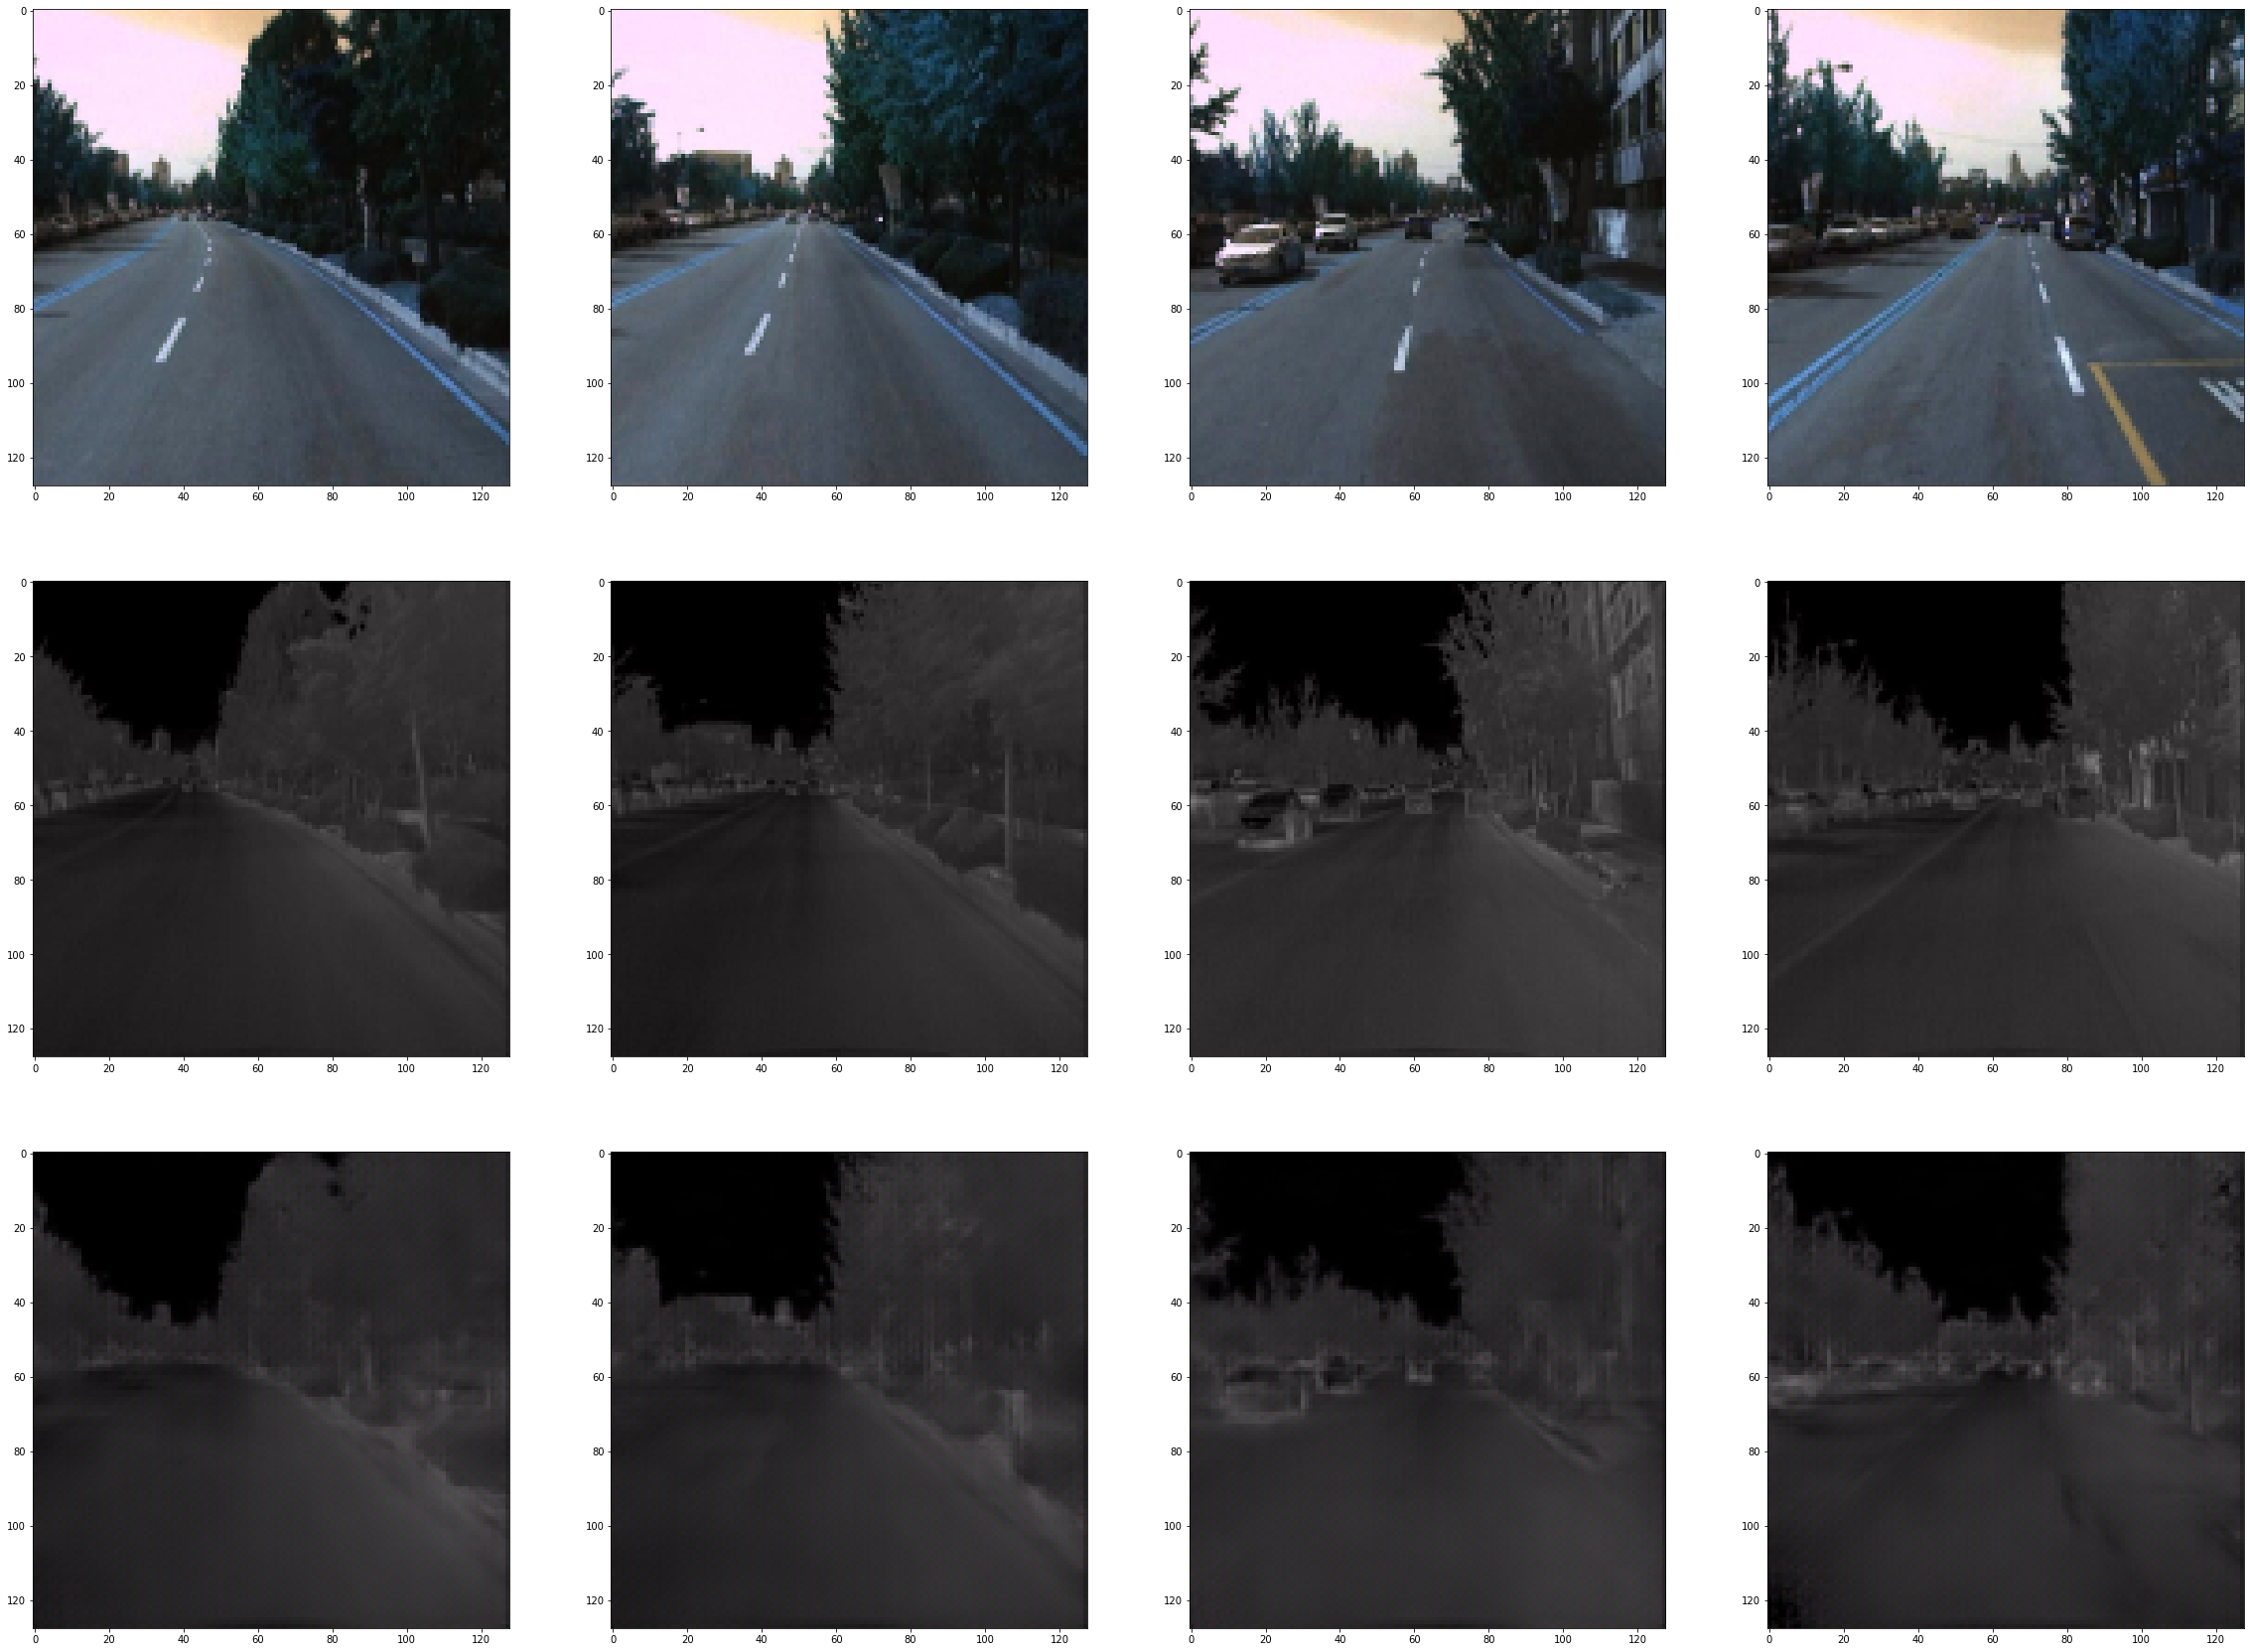

In [14]:
from models import baseline, segformer, segformer_v2
import os
import segmentation_models_pytorch as smp
import pandas as pd
import torch

def row_major_enc(img):
    lst = []
    H,W,C = img.shape
    for i in range(C):
        for j in range(W):
            for k in range(H):
                lst.append(int(img[k][j][i]))  
    return lst

PATH = "models\\unet_plus_plus_v2.pth"
model = smp.UnetPlusPlus(
    encoder_name="resnet34",       
    encoder_weights="imagenet",   
    in_channels=11,                 
    classes=3,                    
)
file_names = os.listdir("val/rgb/")
subDict = {"ID":[], "RMImg": []}
i = 0
# model = smp.Unet(
#     encoder_name="resnet34",       
#     encoder_weights="imagenet",   
#     in_channels=3,                 
#     classes=3,                    
# )
# model = segformer_v2()
model.load_state_dict(torch.load(PATH))
plt.figure(figsize=(BATCH_SIZE*10, 30))
for X,Y in val_loader:
    Y_hat = model(X.float())
    i = 1
    for x,y,y_hat in zip(X,Y,Y_hat):
        plt.subplot(3, BATCH_SIZE, i)
        plt.imshow(torch.round(x[:3]).permute(1, 2, 0).int())
        plt.subplot(3, BATCH_SIZE, i+BATCH_SIZE)
        plt.imshow(y.permute(1, 2, 0))
        plt.subplot(3, BATCH_SIZE, i+2*BATCH_SIZE)
        plt.imshow(torch.round(y_hat.cpu().data.permute(1, 2, 0)).int())
        i+=1
    break
    # rm_img = row_major_enc(op_img)
    # subDict["ID"].append(file_names[i])
    # subDict["RMImg"].append(rm_img)
    

# subPd = pd.DataFrame({"ID": [x for x in subDict["ID"]], 
#                       "RMImg": [x for x in subDict["RMImg"]]})

# subPd.to_csv("submission_.csv", index=False)

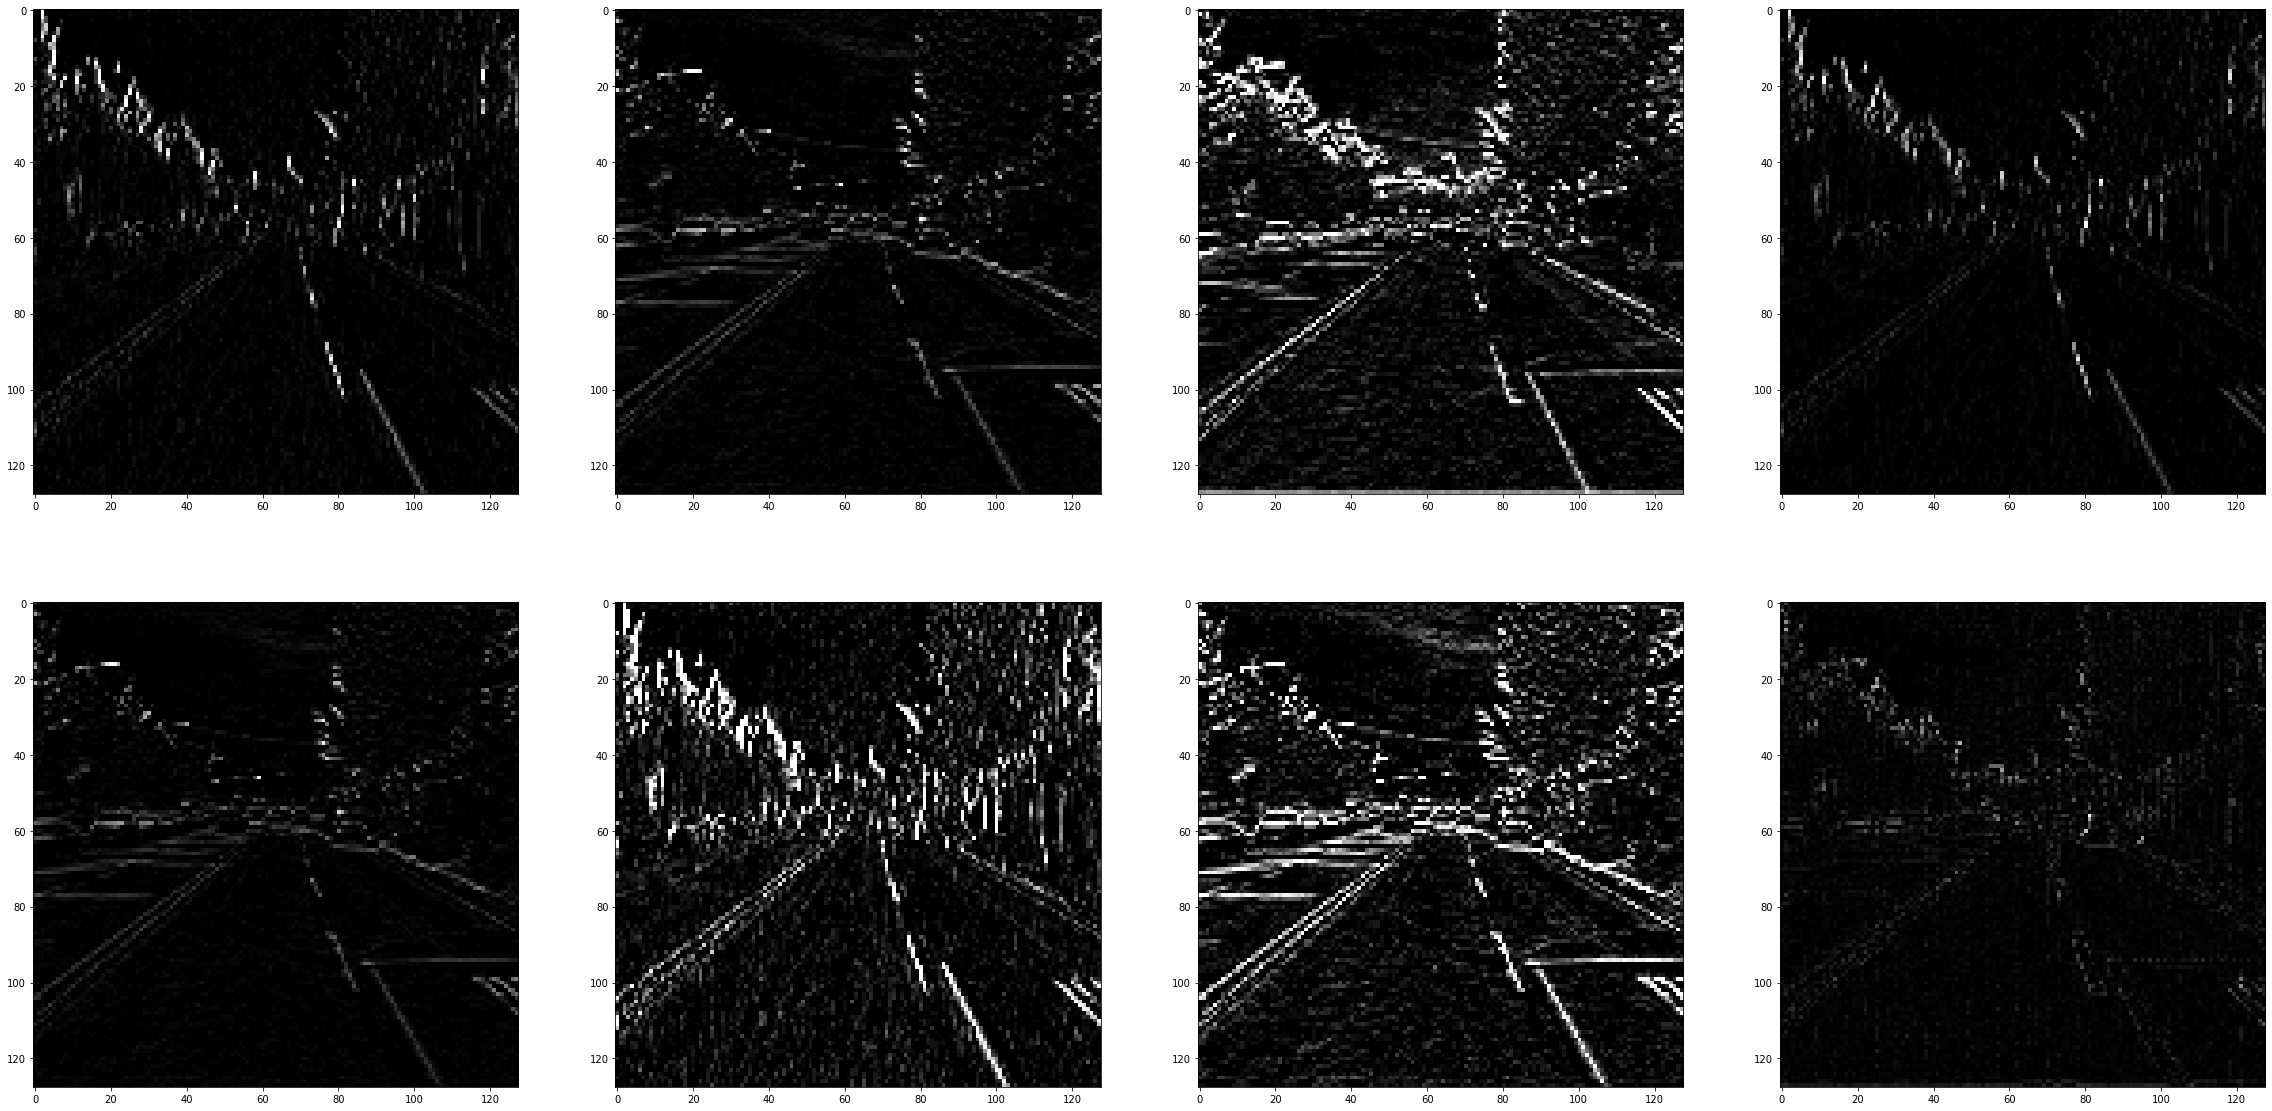

In [19]:
plt.figure(figsize=(40,20))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x[i+3], cmap = "gray")

In [4]:
from models import baseline, segformer, segformer_v2
import os
import segmentation_models_pytorch as smp
import pandas as pd
import torch
import torch.nn.functional as F

BATCH_SIZE = 6
PATH = "models\\unet_plus_plus_v2.pth"
model = smp.UnetPlusPlus(
    encoder_name="resnet34",       
    encoder_weights="imagenet",   
    in_channels=11,                 
    classes=3,                    
)

subDict = {"ID":[], "RMImg": []}
file_names = os.listdir("test/")

convolution_kernels = [np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
                                    np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
                                    np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]),
                                    np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]),
                                    np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]),
                                    np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]),
                                    np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]]),
                                    np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])]

i = 0
# model = smp.Unet(
#     encoder_name="resnet34",       
#     encoder_weights="imagenet",   
#     in_channels=3,                 
#     classes=3,                    
# )
# model = segformer_v2()
model.load_state_dict(torch.load(PATH))
plt.figure(figsize=(BATCH_SIZE*10, 20))

def row_major_enc(img):
    lst = []
    H,W,C = img.shape
    for i in range(C):
        for j in range(W):
            for k in range(H):
                lst.append(int(img[k][j][i]))  
    return lst

for file_name in file_names:
    
    X = cv2.imread("test/"+file_name)
    X = np.array(X)
    additional_channels = []
    for kernel in convolution_kernels:
        result = cv2.filter2D(X, -1, kernel)
        additional_channels.append(result[:, :, 0])  
    additional_channels = np.stack(additional_channels, axis=-1)
    X = np.concatenate((X, additional_channels), axis=-1)
    X = torch.tensor(X).permute(2, 0, 1).float()
    target_size = (128, 128)
    X = F.interpolate(X.unsqueeze(0), size=target_size, mode='bilinear', align_corners=False)
    Y_hat = model(X.float())
    op_img = torch.round(Y_hat.squeeze(0)).int().permute(1, 2, 0)
    rm_img = row_major_enc(op_img)
    subDict["ID"].append(file_names[i])
    subDict["RMImg"].append(rm_img)
    i += 1

subPd = pd.DataFrame({"ID": [x for x in subDict["ID"]], 
                      "RMImg": [x for x in subDict["RMImg"]]})

subPd.to_csv("submission_test.csv", index=False)
    # plt.subplot(2, BATCH_SIZE, i)
    # X = X.squeeze(0)
    # plt.imshow(X[:3].permute(1, 2, 0).int())
    # plt.subplot(2, BATCH_SIZE, i+BATCH_SIZE)
    # plt.imshow(torch.round(Y_hat.cpu().data.squeeze(0).permute(1, 2, 0)).int())
    # i += 1
    

<Figure size 4320x1440 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


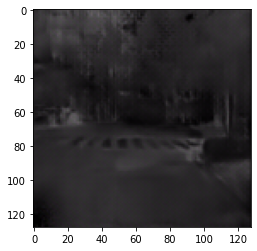

In [8]:
plt.imshow(op_img)

In [7]:
subPd.tail()

ID                                              RMImg
195  6_4_34_I01696.jpg  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
196   6_4_3_I00140.jpg  [48, 59, 57, 55, 63, 70, 64, 63, 74, 81, 72, 6...
197  6_4_47_I02345.jpg  [1, 1, 1, 1, 1, 2, 3, 7, 23, 39, 45, 45, 55, 5...
198   6_4_4_I00195.jpg  [52, 65, 65, 62, 67, 71, 66, 64, 68, 72, 69, 6...
199   6_4_7_I00340.jpg  [37, 46, 45, 45, 49, 52, 48, 49, 52, 55, 50, 4...